# Train Travel Demand Modelling using Python
## 01. Data Pre-processing and Exploratory Data Analysis

This is the first notebook out of 2 which details the steps taken to clean data, engineer new features and visualize preliminary relationships between variables.

- [1. Data Cleaning](#section1)<br/>
    - [1.1 Raw Data Description](#section1.1)<br/>
    - [1.2 Outlier Analysis & Removal](#section1.2)<br/>
    - [1.3 Feature Engineering](#section1.3)<br/>
    - [1.4 Dataset at Daily Granularity](#section1.4)<br/>
- [2. Exploratory Data Analysis on Raw Data](#section2)<br/>
    - [2.1 Analysing Overall Variable Correlations](#section2.1)<br/>
    - [2.2 Analysing Drivers of Ticket Demand](#section2.2)<br/>
    - [2.2 Analysing Drivers of Ticket Price](#section2.3)<br/>
- [3. Clean Transform Data for Modelling](#section3)<br/>
    - [3.1 Drop Redundant Columns](#section3.1)<br/>
    - [3.2 Log Transform Demand & Price](#section3.2)<br/>
- [4. Exploratory Data Analysis on Transformed Data](#section4)<br/>
- [5. Export Data](#section4)<br/>


In [1]:
# Import numerical libraries
import pandas as pd
import numpy as np
import datetime as dt

# Import plotting libraries
import seaborn as sns
from matplotlib import pyplot as plt

## 1. Data Cleaning <a id="section1"></a>

In [2]:
# Import data
df=pd.read_csv('Data-GP1.csv')

# Clean whitespace and convert to lower case
df.columns=[x.strip().lower() for x in df.columns]

# Rename a misspelled column
df.rename(columns={'culmulative_sales':'cumulative_sales', 'train_number_all': 'train'},inplace=True)

# Convert date columns to date format
df.dept_date=pd.to_datetime(df['dept_date'])
df.purchase_date=pd.to_datetime(df['purchase_date'])

df.head()

,num_seats_total,mean_net_ticket_price,dept_date,purchase_date,train,cumulative_sales,isnormcabin,isreturn,isoneway,customer_cat
0,1,188.663422,2019-10-09,2018-10-10,A,1,1,0,0,A
1,1,358.428869,2019-05-27,2018-06-06,B,1,0,1,0,A
2,1,356.372684,2020-05-31,2019-06-17,B,1,0,1,0,A
3,1,396.370505,2019-12-10,2018-12-27,C,1,0,1,0,A
4,1,364.264552,2020-05-31,2019-06-19,B,2,0,1,0,A


### 1.1 Raw Data Description <a id="section1.1"></a>

There are 209,697 rows in the data set and 10 features in total. Each line represents a unique purchase transaction for purchases from Jun-2018 to Jun-2019.

- *num_seats_total*: Number of seats bought on that purchase_date. (<b>Target variable, Y</b>)
- *mean_net_ticket_price*: Mean ticket price paid in that particular purchase transaction.
- *dept_date*: Train departure date.
- *purchase_date*: Ticket purchase date.
- *train*: Alphabet representing a unique train identifier\*.
- *cumulative_sales*: Total seats sold for a particular train's departure date. 
- *isnormcabin*: Boolean value (0/1) to identify normal vs premium cabins.
- *isreturn*: Boolean value (0/1) to identify return to the train's base station.
- *isoneway*: Boolean value (0/1) to identify if ticket is one-way or includes return.
- *customer_cat*: Two customer categories, A & B.

\*It is not known what differentiates trains, although it is hypothesized that these may be different routes or different timings.

In [3]:
# Set all floats to display only 2 decimal points
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Print numerical summary, including text and date features for completeness
df.describe(include = 'all', datetime_is_numeric=True).transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
num_seats_total,209697.00,NaN,NaN,NaN,2.38,1.00,1.00,2.00,3.00,66.00,2.08
mean_net_ticket_price,209697.00,NaN,NaN,NaN,230.12,1.28,108.87,186.28,350.41,7855.77,147.02
dept_date,209697,NaN,NaN,NaN,2019-02-19 18:47:47.783516416,2018-06-01 00:00:00,2018-11-05 00:00:00,2019-02-21 00:00:00,2019-05-27 00:00:00,2020-06-13 00:00:00,NaN
purchase_date,209697,NaN,NaN,NaN,2018-12-18 12:26:46.683929856,2018-06-01 00:00:00,2018-09-07 00:00:00,2018-12-19 00:00:00,2019-04-02 00:00:00,2019-06-30 00:00:00,NaN
train,209697,15,B,26855,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cumulative_sales,209697.00,NaN,NaN,NaN,15.88,1.00,3.00,8.00,21.00,187.00,19.80
isnormcabin,209697.00,NaN,NaN,NaN,0.60,0.00,0.00,1.00,1.00,1.00,0.49
isreturn,209697.00,NaN,NaN,NaN,0.48,0.00,0.00,0.00,1.00,1.00,0.50
isoneway,209697.00,NaN,NaN,NaN,0.12,0.00,0.00,0.00,0.00,1.00,0.33
customer_cat,209697,2,B,162404,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Outlier Analysis & Removal <a id="section1.2"></a>

From inspecting the data summary above, it can be seen that there may be outlier issues in num_seats_total as well as mean_net_ticket_price. 

The box plots below confirm this. 

In [4]:
def outlier_check(var, df_name):
    sns.boxplot(x = df_name[var])
    print('Variable: ', var) 
    print('Minimum value: ', df_name[var].min())
    print('10th percentile: ', df_name[var].quantile(0.1))
    print('90th percentile: ', df_name[var].quantile(0.90))
    print('95th percentile: ', df_name[var].quantile(0.95))
    print('97th percentile: ', df_name[var].quantile(0.97))
    print('Maximum value: ', df_name[var].max())

Summary Statistics Before Treatment
Variable:  num_seats_total
Minimum value:  1
10th percentile:  1.0
90th percentile:  5.0
95th percentile:  6.0
97th percentile:  8.0
Maximum value:  66


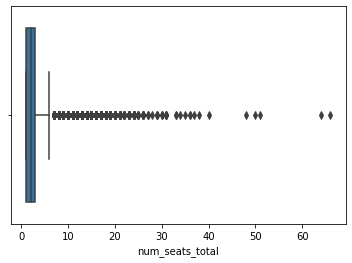

In [5]:
print("Summary Statistics Before Treatment")
outlier_check('num_seats_total', df)

Summary Statistics Before Treatment
Variable:  mean_net_ticket_price
Minimum value:  1.278969082
10th percentile:  90.750834978
90th percentile:  428.08725202
95th percentile:  513.4909683599999
97th percentile:  577.680626356
Maximum value:  7855.766106


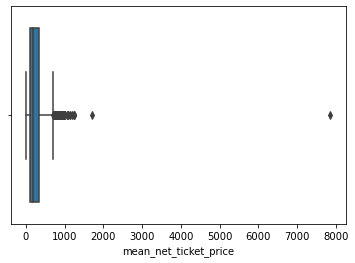

In [6]:
print("Summary Statistics Before Treatment")
outlier_check('mean_net_ticket_price', df)

<b> Dropping Outliers </b>

In this analysis, outliers are dropped rather than capped because they are likely to be either errors or transactions so infrequent that they do not reflect typical buying behavior. For example, the maximum mean_ticket_price was \$7855 and for this price, it is likely that the individual should have considered an airline instead.  

Here, the <b> 97th percentile</b> is used as a cutoff to use for dropping outliers. 

In [7]:
# Custom function to treat outliers
def outlier_treatment(var, df_name, min_treat, max_treat, min_quantile = 0.05, max_quantile = 0.95):
    min = df_name[var].quantile(min_quantile)
    max = df_name[var].quantile(max_quantile)
    if min_treat == 1:
        df_name.loc[df_name[var] <= min, var] =  np.nan
    if max_treat == 1:
        df_name.loc[df_name[var] >= max, var] =  np.nan
    df_name.dropna(inplace = True)
    
    return df_name[[var]].describe().transpose()

Summary Statistics After Treatment
Variable:  num_seats_total
Minimum value:  1.0
10th percentile:  1.0
90th percentile:  4.0
95th percentile:  5.0
97th percentile:  6.0
Maximum value:  7.0


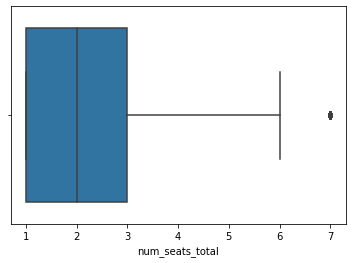

In [8]:
# Apply outlier treatment to num_seats_total
outlier_treatment(var = 'num_seats_total', df_name = df, min_treat = 0, max_treat = 1, max_quantile = 0.97)

print("Summary Statistics After Treatment")
outlier_check('num_seats_total', df)

Summary Statistics After Treatment
Variable:  mean_net_ticket_price
Minimum value:  1.278969082
10th percentile:  90.845755326
90th percentile:  400.7971242600003
95th percentile:  464.25227714
97th percentile:  473.917419184
Maximum value:  579.060649


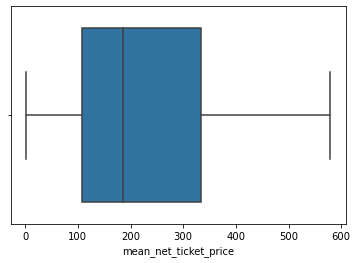

In [9]:
# Apply outlier treatment to mean_net_ticket_price
outlier_treatment(var = 'mean_net_ticket_price', df_name = df, min_treat = 0, max_treat = 1, max_quantile = 0.97)

print("Summary Statistics After Treatment")
outlier_check('mean_net_ticket_price', df)

### 1.3. Feature Engineering <a id="section1.3"></a>

Besides the features given, these other features are hypothesized to be useful:
- *buy_lead_time*: How far in advance the ticket was purchased relative to departure date (dept_date - purchase_date)
- *dept_dayofweek*: Monday is day 1 and so forth until Sunday (day 7)
- *dept_month*: Month of departure

In [10]:
# buy_lead_time
df['buy_lead_time']=df['dept_date']-df['purchase_date']
df['buy_lead_time']=df['buy_lead_time'].astype('timedelta64[D]')

# dept_isweekend was tried but proved less useful than the raw dayofweek
#df['dept_isweekend']=(df.dept_date).dt.weekday+1 # added 1 to ensure 1 corresponds to Monday
#df['dept_isweekend'].replace([1,2,3,4,5],0,inplace = True)
#df['dept_isweekend'].replace([6,7],1,inplace = True)

# dept_dayofweek
df['dept_dayofweek']=(df.dept_date).dt.weekday+1

# dept_month
df['dept_monthnum']=(df.dept_date).dt.month

df.head()

,num_seats_total,mean_net_ticket_price,dept_date,purchase_date,train,cumulative_sales,isnormcabin,isreturn,isoneway,customer_cat,buy_lead_time,dept_dayofweek,dept_monthnum
0,1.00,188.66,2019-10-09,2018-10-10,A,1,1,0,0,A,364.00,3,10
1,1.00,358.43,2019-05-27,2018-06-06,B,1,0,1,0,A,355.00,1,5
2,1.00,356.37,2020-05-31,2019-06-17,B,1,0,1,0,A,349.00,7,5
3,1.00,396.37,2019-12-10,2018-12-27,C,1,0,1,0,A,348.00,2,12
4,1.00,364.26,2020-05-31,2019-06-19,B,2,0,1,0,A,347.00,7,5


### 1.4 Dataset at Daily Granularity <a id="section1.4"></a>

With outliers removed, the dataset now consists of 197,233 transactions.

In [11]:
# Print numerical summary, including text and date features for completeness
df.describe(include = 'all', datetime_is_numeric=True).transpose()

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
num_seats_total,197233.00,NaN,NaN,NaN,2.15,1.00,1.00,2.00,3.00,7.00,1.46
mean_net_ticket_price,197233.00,NaN,NaN,NaN,219.22,1.28,108.67,185.59,333.68,579.06,128.01
dept_date,197233,NaN,NaN,NaN,2019-02-19 22:20:56.394214144,2018-06-01 00:00:00,2018-11-04 00:00:00,2019-02-21 00:00:00,2019-05-27 00:00:00,2020-06-13 00:00:00,NaN
purchase_date,197233,NaN,NaN,NaN,2018-12-18 00:51:51.982275072,2018-06-01 00:00:00,2018-09-07 00:00:00,2018-12-18 00:00:00,2019-04-02 00:00:00,2019-06-30 00:00:00,NaN
train,197233,14,B,24897,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cumulative_sales,197233.00,NaN,NaN,NaN,15.54,1.00,3.00,8.00,21.00,187.00,19.34
isnormcabin,197233.00,NaN,NaN,NaN,0.61,0.00,0.00,1.00,1.00,1.00,0.49
isreturn,197233.00,NaN,NaN,NaN,0.48,0.00,0.00,0.00,1.00,1.00,0.50
isoneway,197233.00,NaN,NaN,NaN,0.12,0.00,0.00,0.00,0.00,1.00,0.32
customer_cat,197233,2,B,153610,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Exploratory Data Analysis on Raw Data <a id="section2"></a>

### 2.1 Analysing Overall Variable Correlations <a id="section2.1"></a>

It can already be seen that there are some interesting (and sensible) correlations with demand (*num_seats_total*):
- As price (*mean_net_ticket_price*) increases, demand for seats (*num_seats_total*) decreases
- Demand is higher for normal cabins (*isnormcabin*) than for premium ones
- Trip features (*isreturn, isoneway*) do not seem to influence demand

It can also be seen that some variables have strong correlations with price (*mean_net_ticket_price*):
- Normal cabins (*isnormcabin*) are cheaper than premium cabins
- Buying a trip in advance (*buy_lead_time*) is also associated with a reduction in price
- Buying a one-way trip (*isoneway* = 1) is more expensive

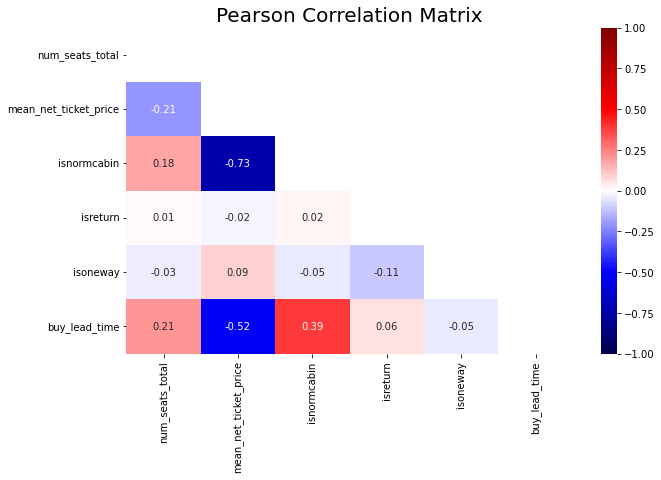

In [12]:
plt.figure(figsize=(10, 6))

# Remove categorical columns
cols = df.columns.tolist()
corr_cols = [e for e in cols if e not in ('dept_monthnum', 'dept_dayofweek', 'cumulative_sales')]

corr_matrix = df[corr_cols].corr()
mask = np.triu(np.ones_like(df[corr_cols].corr(), dtype=bool))
sns.heatmap(data= corr_matrix, mask = mask, cmap='seismic', vmax = 1, vmin=-1, annot=True, fmt='0.2f')
plt.title('Pearson Correlation Matrix', fontsize = 20)
plt.show()

### 2.2 Analysing Drivers of Ticket Demand <a id="section2.2"></a>

Besides the correlations noted above, cabin type ticket demand (*num_seats_total*) should vary by day of the week and train type as well. These are demonstrated below. 

<b> Day of Week & Ticket Demand </b>

Overall, the most tickets are sold for Friday and Sunday which makes sense as presumably commuters head out from the city to the suburbs / country for the weekend on Friday, and then head back on Sunday.

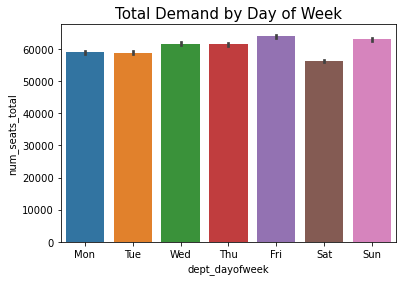

In [13]:
g = sns.barplot(x = 'dept_dayofweek', y= 'num_seats_total', data = df, estimator=sum)
g.set(xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Total Demand by Day of Week', fontsize = 15)
plt.show()

<b> Train ID & Ticket Demand </b>

There are marked differences in usage of each train, with B and E having the highest demand and N having the lowest. This suggest that this variable is very imporatant for the model.

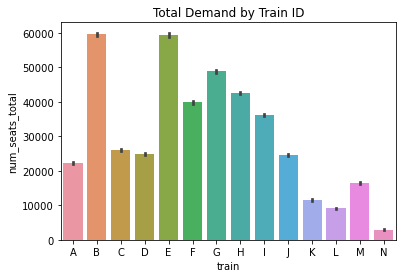

In [14]:
g_month = sns.barplot(x = 'train', y= 'num_seats_total', data = df, estimator=sum)
plt.title('Total Demand by Train ID')
plt.show()

### 2.3 Analysing Drivers of Ticket Price <a id="section2.3"></a>

Although price is just one independent variable in the demand equation, as an endogenous variable (to be shown in *02_Demand_Modelling_with_2SLS.ipynb*), the price equation will also be modeled and used to cleanse the demand equation of endogeneity. Hence, it is worth spending some time to understand the key drivers of price. 

<b> Cabin Type, Customer Type & Ticket Price </b>

Diving deeper into correlations with price (*mean_net_ticket_price*), it can be seen that:
- Normal cabins (*isnormcabin* = 1) are cheaper than premium cabins (*isnormcabin* = 0) 
- Customers in category B pay significantly less for their tickets compared to those in A. This suggests that category B may be a super saver pass of sorts. 

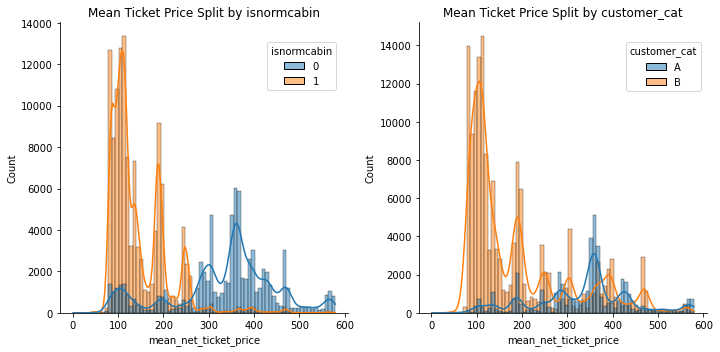

In [15]:
fig = plt.figure(figsize=[15,5])

features = ['isnormcabin', 'customer_cat']

for i in range(len(features)):    
    fig.add_subplot(1, 3, i+1)
    ax = sns.histplot(data=df,x=df['mean_net_ticket_price'], hue = features[i], kde = True)
    ax.title.set_text('Mean Ticket Price Split by {}'.format(features[i]))
    ax.legend_.set_bbox_to_anchor((0.7, 0.95))
    ax.legend_._set_loc(2)
    sns.despine()

plt.tight_layout()
plt.show()

<b> Advance Purchase & Ticket Price </b>

As observed in the initial correlation matrix in section 2.1, buying a trip in advance (buy_lead_time) is also associated with a reduction in price. It can also be seen that there is a long tail trend here, where the price increase associated with the initial 50 days is very steep and tapers off quickly for all subsequent time periods. 

*Note that graph has been truncated at the 250th day (97th percentile) as not all train/ticket combinations are available for purchase so far in advance, leading to skewed averages.*

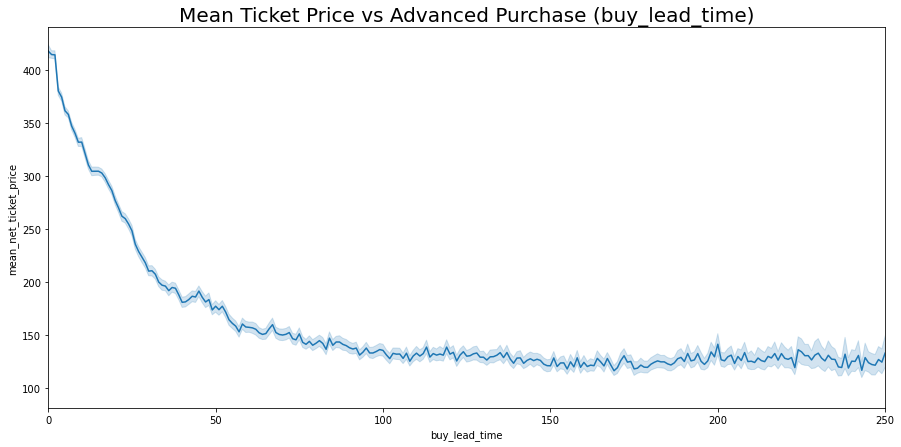

In [16]:
plt.figure(figsize=(15,7))
sns.lineplot(data = df, x='buy_lead_time', y='mean_net_ticket_price')
plt.title('Mean Ticket Price vs Advanced Purchase (buy_lead_time)', fontsize = 20)
plt.xlim(0,250)
plt.show()

## 3. Aggregate & Transform Data for Modeling <a id="section3"></a>

### 3.1 Drop Redundant Columns <a id="section3.1"></a>

Following EDA and feature creation, columns that are not needed for demand modelling are dropped. These are:
- *cumulative_sales*: This itself is an aggregated measure and is not useful for modelling.
- *purchase_date*: This is already captured in buy_lead_time.
- *dept_date*: This can be analysed at a higher level of detail (weekend vs weekday) to provide a clearer trend for analysis.

In [17]:
agg_df = df.copy()

# Drop columns not needed
cols = ['cumulative_sales','dept_date','purchase_date']
agg_df.drop(cols, axis = 1, inplace = True)

In [18]:
agg_df.head()

,num_seats_total,mean_net_ticket_price,train,isnormcabin,isreturn,isoneway,customer_cat,buy_lead_time,dept_dayofweek,dept_monthnum
0,1.00,188.66,A,1,0,0,A,364.00,3,10
1,1.00,358.43,B,0,1,0,A,355.00,1,5
2,1.00,356.37,B,0,1,0,A,349.00,7,5
3,1.00,396.37,C,0,1,0,A,348.00,2,12
4,1.00,364.26,B,0,1,0,A,347.00,7,5


### 3.2 Log Transform Demand & Price <a id="section3.2"></a>

Log transformations are applied to both demand and price. 

With log transformation, these variables can now be interpreted as percentage changes which is more intuitive as we typically think of percentage changes in price causing percentage changes in demand, rather than fixed dollar amounts.

In [19]:
agg_df['num_seats_total'] = np.log(agg_df['num_seats_total'])
agg_df['mean_net_ticket_price'] = np.log(agg_df['mean_net_ticket_price'])

For clarity of visualisations, text fields *train* and *customer_cat* will only be dummified in the subsequent regression model notebook. 

In [20]:
# Print numerical summary, including text and date features for completeness
agg_df.describe(include = 'all', datetime_is_numeric=True).transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
num_seats_total,197233.00,NaN,NaN,NaN,0.57,0.60,0.00,0.00,0.69,1.10,1.95
mean_net_ticket_price,197233.00,NaN,NaN,NaN,5.22,0.58,0.25,4.69,5.22,5.81,6.36
train,197233,14,B,24897,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isnormcabin,197233.00,NaN,NaN,NaN,0.61,0.49,0.00,0.00,1.00,1.00,1.00
isreturn,197233.00,NaN,NaN,NaN,0.48,0.50,0.00,0.00,0.00,1.00,1.00
isoneway,197233.00,NaN,NaN,NaN,0.12,0.32,0.00,0.00,0.00,0.00,1.00
customer_cat,197233,2,B,153610,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buy_lead_time,197233.00,NaN,NaN,NaN,63.90,64.79,0.00,16.00,41.00,92.00,364.00
dept_dayofweek,197233.00,NaN,NaN,NaN,4.03,1.99,1.00,2.00,4.00,6.00,7.00
dept_monthnum,197233.00,NaN,NaN,NaN,6.71,3.45,1.00,4.00,7.00,10.00,12.00


## 4. Exploratory Data Analysis on Transformed Data <a id="section4"></a>

Re-running the correlation matrix below demonstrates that log transformation has helped to strengthen the correlation between mean_net_ticket_price from -0.21 above to -0.27 here which is significant. The rest of the relationships remain similar. 

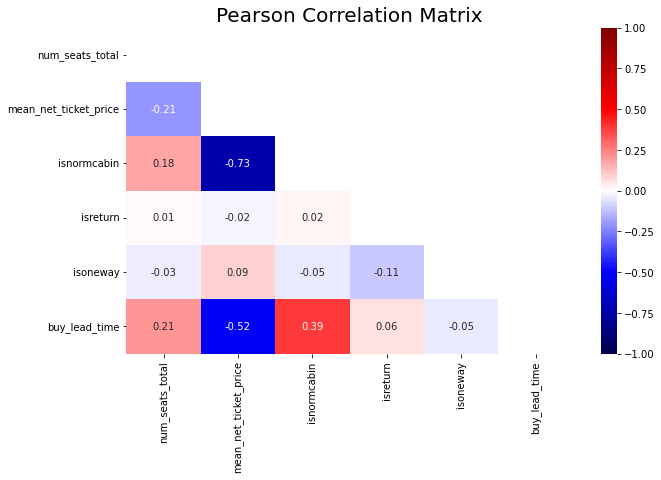

In [21]:
plt.figure(figsize=(10, 6))

# Remove categorical columns
cols = agg_df.columns.tolist()
corr_cols = [e for e in cols if e not in ('dept_monthnum', 'dept_dayofweek', 'cumulative_sales')]

corr_matrix = df[corr_cols].corr()
mask = np.triu(np.ones_like(df[corr_cols].corr(), dtype=bool))
sns.heatmap(data= corr_matrix, mask = mask, cmap='seismic', vmax = 1, vmin=-1, annot=True, fmt='0.2f')
plt.title('Pearson Correlation Matrix', fontsize = 20)
plt.show()

## 5. Export Dataset<a id="section5"></a>

This dataset is used in *02_Demand_Modelling_with_linearmodels.ipynb* to demonstrate how to deal with the problem of endogeneity.

In [22]:
agg_df.to_csv('clean_data.csv', index = False)